In [12]:
import cv2                       
import numpy as np                
import matplotlib.pyplot as plt 
%matplotlib inline
from opening import custom_opening_rectangle
from erosion import custom_erosion_rectangle
from delation import custom_dilation_rectangle
from closing import custom_closing_rectangle

In [13]:
image = cv2.imread('data/archive(1)/images/source.png')

In [14]:
def show_image(img, title, colorspace):
    dpi = 96
    figsize = (img.shape[1] / dpi, img.shape[0] / dpi)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    if colorspace == 'RGB':
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='spline16')
    elif colorspace == 'gray':
        plt.imshow(img, cmap='gray')
    plt.title(title, fontsize=12)
    ax.axis('off')
    plt.show()


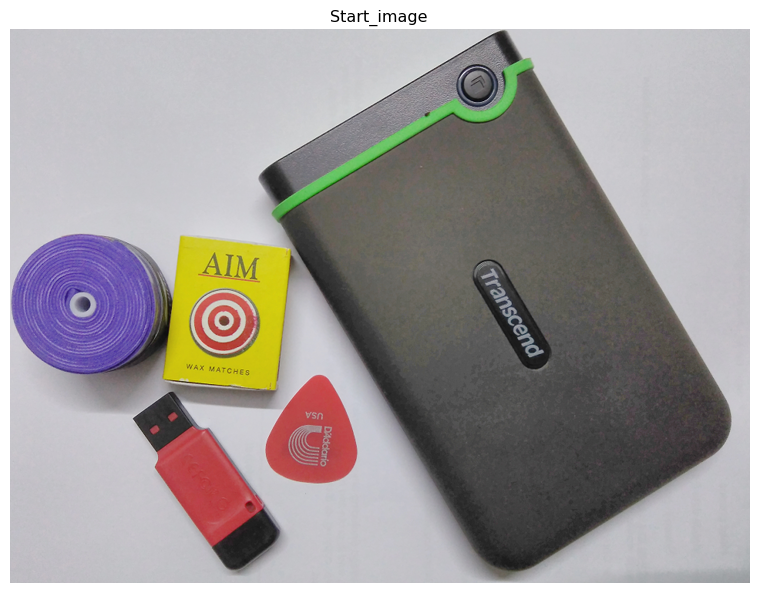

In [15]:
show_image(image, 'Start_image', 'RGB')

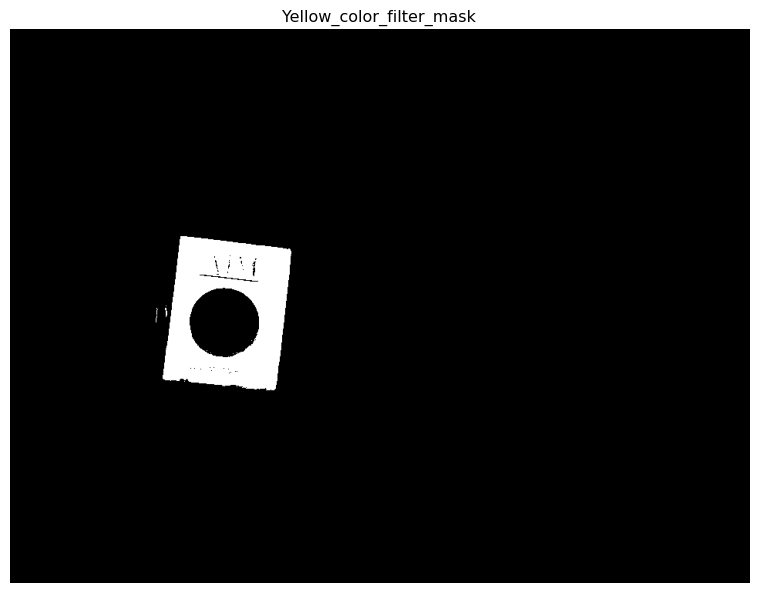

In [16]:

src_img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

yellow_lower = np.array([16, 100, 100])
yellow_upper = np.array([45, 255, 255])

mask = cv2.inRange(src_img_hsv, yellow_lower, yellow_upper)

show_image(mask, 'Yellow_color_filter_mask', 'gray')



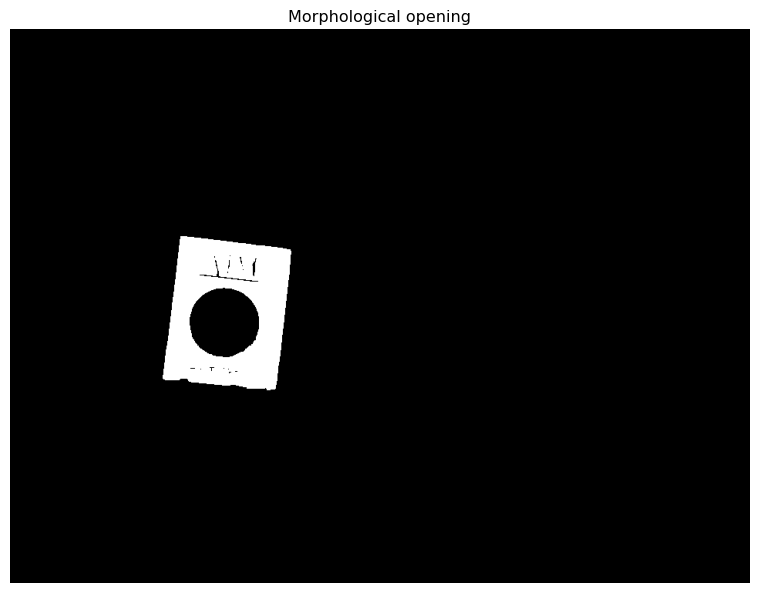

In [17]:
kernel = np.ones((5, 5), np.uint8)
c = custom_opening_rectangle(mask, kernel)
show_image(c, 'Morphological opening', 'gray')

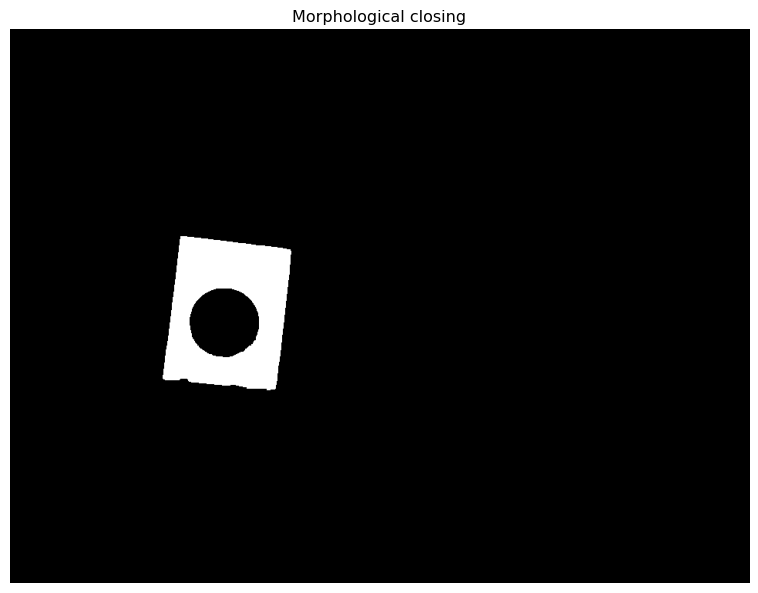

In [18]:
c1 = custom_closing_rectangle(c, kernel)

show_image(c1, 'Morphological closing', 'gray')

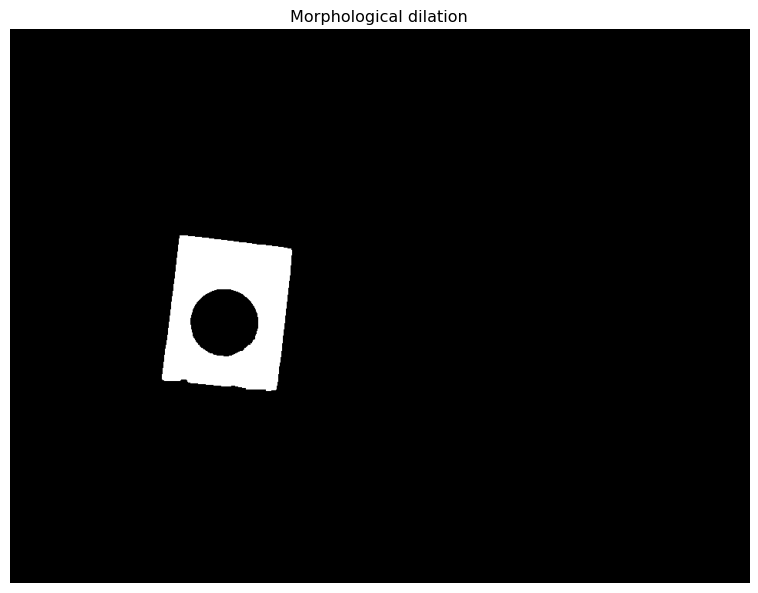

In [19]:
kernel1 = np.ones((3, 3), np.uint8)
d = custom_dilation_rectangle(c1, kernel1)

show_image(d, 'Morphological dilation', 'gray')

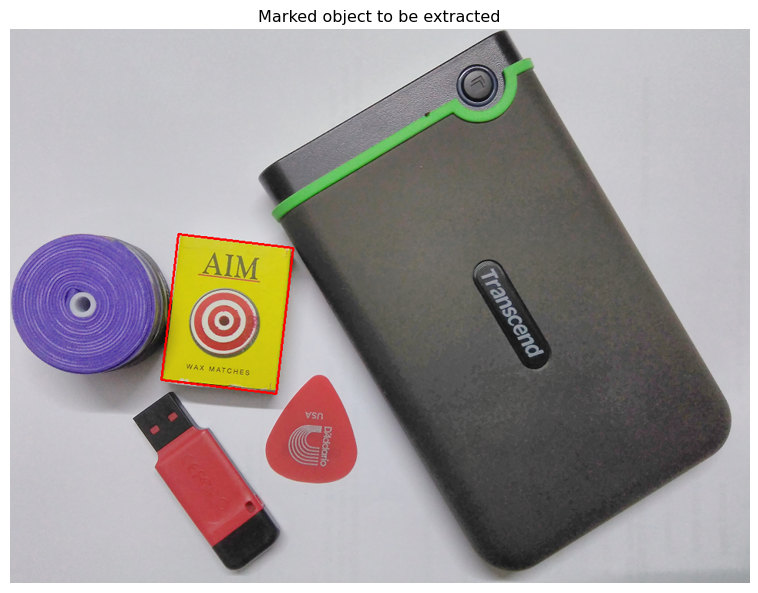

In [20]:
contours, _ = cv2.findContours(d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
k = max(contours, key = cv2.contourArea)
rect = cv2.minAreaRect(k)

box = cv2.boxPoints(rect)
box = np.int0(box)
temp_img = image.copy()
bdg_rect = cv2.drawContours(temp_img, [box], 0, (0, 0, 255), 2)

show_image(bdg_rect, 'Marked object to be extracted', 'RGB')

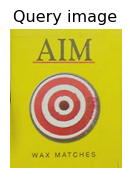

In [39]:
rect = cv2.minAreaRect(k)
box = cv2.boxPoints(rect)
box = np.int0(box)

x_min = np.min(box[:, 0])
x_max = np.max(box[:, 0])
y_min = np.min(box[:, 1])
y_max = np.max(box[:, 1])

padding = -13
x_min -= padding
x_max += padding
y_min -= padding
y_max += padding

cropped_image = image[y_min:y_max, x_min:x_max]

angle = rect[2] 
if angle < -45:
    angle += 90
(h, w) = cropped_image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated_image = cv2.warpAffine(cropped_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)



show_image(rotated_image, 'Query image', 'RGB')


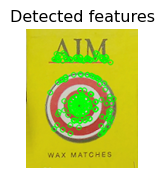

In [41]:

orb = cv2.ORB_create()
features = orb.detect(rotated_image, None)
f_img = cv2.drawKeypoints(rotated_image, features, None, color = (0, 255, 0), flags = 0)

show_image(f_img, 'Detected features', 'RGB')

In [42]:
def match_feature_find_object(query_img, train_img, min_matches): 
    orb = cv2.ORB_create(nfeatures=100000)
    
    features1, des1 = orb.detectAndCompute(query_img, None)
    features2, des2 = orb.detectAndCompute(train_img, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k = 2)
    good = []    
    good_without_lists = []    
    matches = [match for match in matches if len(match) == 2] 
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append([m])
            good_without_lists.append(m)
         
    if len(good) >= min_matches:
        src_pts = np.float32([features1[m.queryIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)
        dst_pts = np.float32([features2[m.trainIdx].pt for m in good_without_lists]).reshape(-1, 1, 2)
        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        h, w = query_img.shape[:2]
        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)
        
        train_img = cv2.polylines(train_img, [np.int32(dst)], True, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        print('Not enough good matches are found - {}/{}'.format(len(good), min_matches))
            
    result_img = cv2.drawMatchesKnn(query_img, features1, train_img, features2, good, None, flags = 2)
    
    show_image(result_img, 'Feature matching and object recognition', 'RGB')

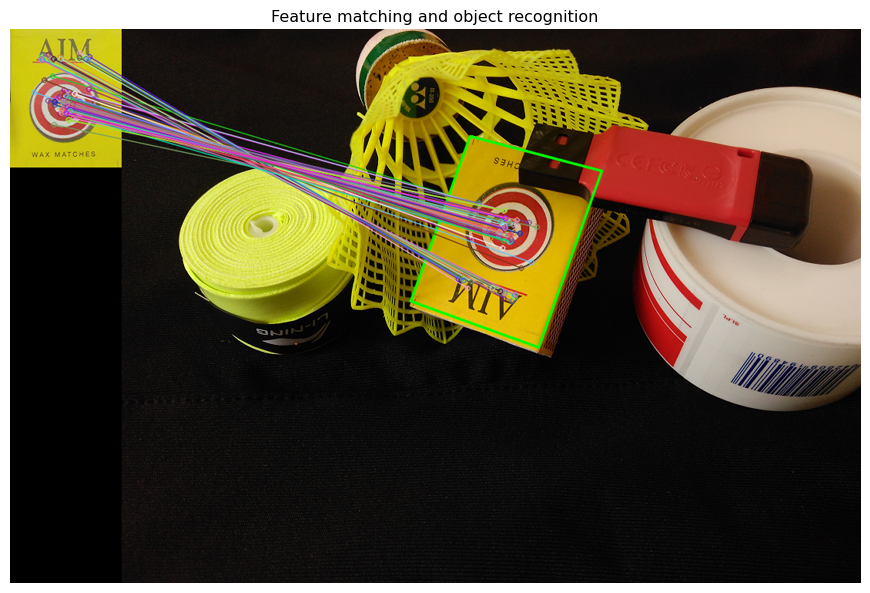

In [43]:
train_img = cv2.imread('data/archive(1)/images/train1.png')
match_feature_find_object(rotated_image, train_img, 10)



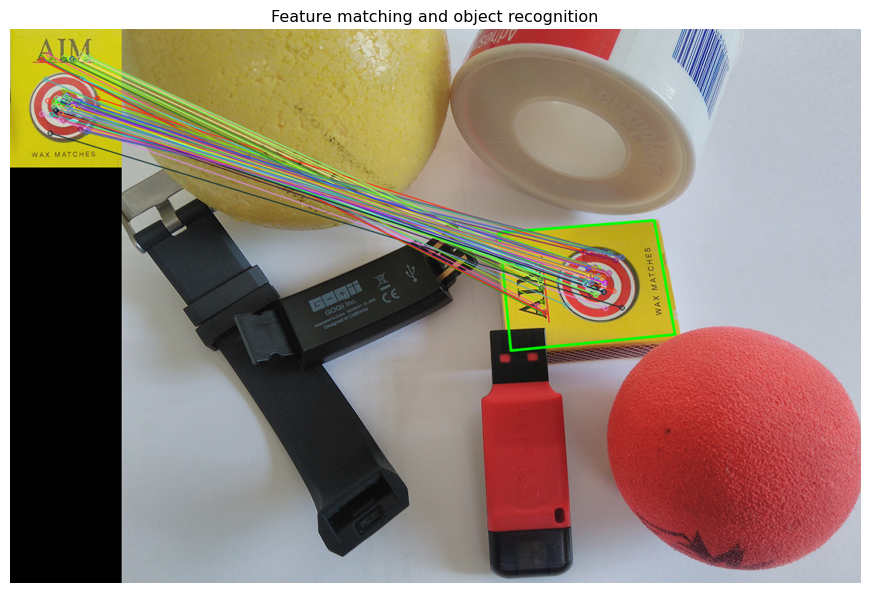

In [44]:
train_img = cv2.imread('data/archive(1)/images/train2.png')
match_feature_find_object(rotated_image, train_img, 10)

Not enough good matches are found - 0/10


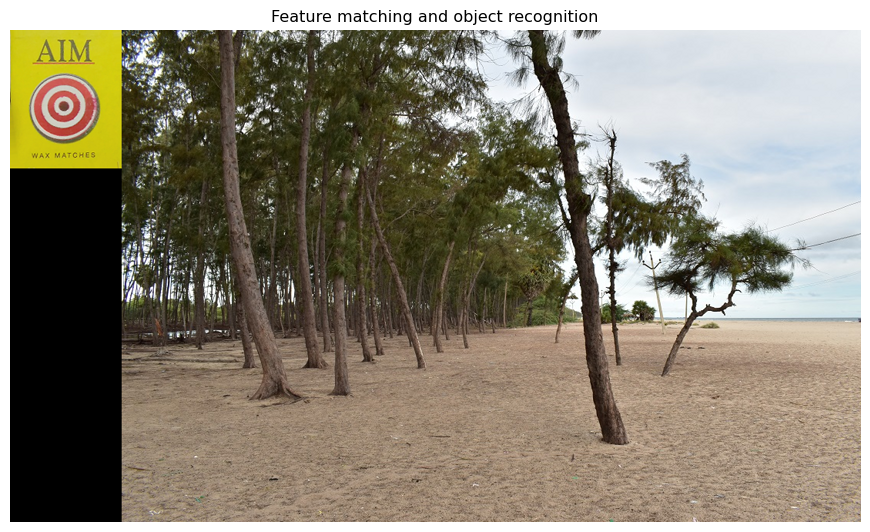

In [46]:


# Image without the matchbox
train_img = cv2.imread('data/archive(1)\images/train7.jpg')
match_feature_find_object(rotated_image, train_img, 10)



